In [61]:
from pathlib import Path
import time

import pylab as pl
from IPython import display
import torch
from torch.distributions import Categorical
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import numpy as np

from riemannianSgd import RiemannianSGD
from model import Model
import helpers

OUT_DIMENSIONS = 2
NEG_SAMPLES = 15
EPOCH = 300

In [62]:
data, objects, weights = helpers.load_edge_list(Path("data", "dist1Sample.csv"))
# id2 = ancestor, id1 = descendant according to descendant name in near column
# "ancestor_concept_id","descendant_concept_id","dist"
# "id2","id1","weight","descendant_concept_name"
print(data.shape)
print(objects)
print(len(objects))
print(weights)
ref = pd.read_csv(Path('data','ref.csv'))
#create a dict with data indices as keys
dictData = dict(enumerate(objects))
# replace concept_id with concept_name in dict
for key, value in dictData.items():
    dictData[key] = ref.loc[ref['concept_id'] == value].concept_name.values[0]

# print(dictData)

(184, 2)
[432250, 4274025, 443883, 4020158, 4152604, 42709887, 443404, 4179873, 4176962, 444202, 432795, 4260204, 4299449, 4193506, 4179872, 37018844, 4177703, 4279309, 440508, 4300177, 444201, 44812002, 4311117, 4185471, 4170068, 4041682, 4316210, 40403168, 4027868, 37394537, 4214726, 42537547, 192667, 4219363, 4109783, 4104922, 433604, 4018852, 4315821, 37018592, 435247, 440930, 37398744, 4310298, 4070203, 4047767, 4049014, 4342882, 35622759, 4250505, 42538941, 4095572, 4330231, 4066421, 4248518, 4221139, 4331815, 4270770, 4095561, 37116656, 4189234, 4117110, 4251765, 4291443, 4085415, 44783894, 3662317, 4178492, 36716317, 36716109, 4119169, 37116412, 4126275, 761287, 4297918, 4138450, 4096761, 4140828, 4012261, 4096938, 4130331, 4035787, 37109699, 4324126, 4302044, 4033912, 4341083, 4270705, 4080749, 4096644, 4048484, 4173076, 4301400, 4326962, 4096781, 4152492, 4193496, 36716442, 4162439, 4095878, 37116389, 133965, 4025216, 4173032, 4330644, 198978, 762954, 200334, 200040, 36674379

Graph with 174 nodes and 184 edges


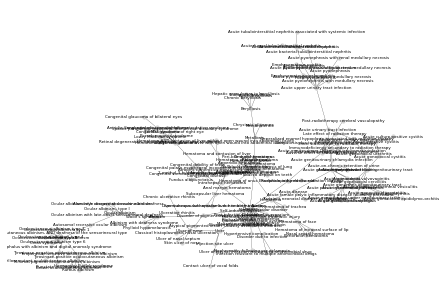

In [63]:
g = nx.Graph()
g.add_edges_from(data)

pos = nx.spring_layout(g)
# pos = nx.kamada_kawai_layout(g)
pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0], coords[1] + 0.08)

print(nx.info(g))
plt.figure()
nx.draw(g, pos=pos, node_size=10, node_color="lightgray", width=0.2)
nx.draw_networkx_labels(g, labels=dictData, pos=pos, font_size=4)
plt.savefig(Path("data", "hierarchy.png"), dpi=300)
plt.show()

In [64]:
# cat_dist = Categorical(probs=torch.from_numpy(weights)) # was weights
cat_dist = Categorical(probs=torch.from_numpy(np.ones(len(objects)))) # was weights
# print(np.ones(len(objects)))
#print(len(np.ones(len(objects))))
unif_dist = Categorical(probs=torch.ones(len(objects),) / len(objects))
# print(torch.ones(len(objects),) / len(objects))

# model = Model(dim=OUT_DIMENSIONS, size=data.shape[0])
model = Model(dim=OUT_DIMENSIONS, size=len(objects))

optimizer = RiemannianSGD(model.parameters())

loss_func = CrossEntropyLoss()
batch_X = torch.zeros(10, NEG_SAMPLES + 2, dtype=torch.long)
batch_y = torch.zeros(10, dtype=torch.long)

EPOCH = 500
n = 0

100%|██████████| 18/18 [00:00<00:00, 848.62it/s]


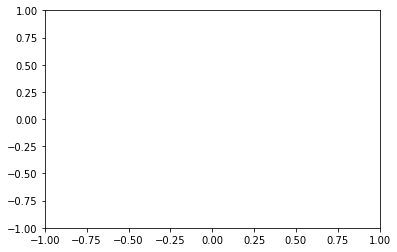

In [65]:
pl.figure()
pl.xlim(-1, 1)
pl.ylim(-1, 1)
# pl.axis('off')

while n < EPOCH:
    if EPOCH < 20:
        lr = 0.003
        sampler = cat_dist
    else:
        lr = 0.3
        sampler = unif_dist

    perm = torch.randperm(data.shape[0])
    # dataset_rnd = data.loc[perm, ]
    dataset_rnd = torch.as_tensor(data[perm, ])

##############################################
    # coordinates = model.embedding.weight.detach().numpy()
    # # pl.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
    # pl.gca().clear()
    # pl.xlim(-1, 1)
    # pl.ylim(-1, 1)
    # pl.title(n)
    # pl.scatter(coordinates[:,0], coordinates[:,1])
    # display.clear_output(wait=True)
    # display.display(pl.gcf())
##############################################

    for i in tqdm(range(0, data.shape[0] - data.shape[0] % 10, 10)):
        batch_X[:, :2] = dataset_rnd[i: i + 10]

        for j in range(10):
            a = set(sampler.sample([2 * NEG_SAMPLES]).numpy())
            # print("a")
            # print(a)
            # print("BATCHX0")
            # print(data[batch_X[j, 0]])
            # print(set(data[batch_X[j, 0]]))
            # print("BATCHX1")
            # print(data[batch_X[j, 1]])
            # print(set(data[batch_X[j, 1]]))
            # print("positives")
            # print((set(data[batch_X[j, 0]]) | set(data[batch_X[j, 1]])))
            # print("a")
            # print(a)
            negatives = list(a - (set(data[batch_X[j, 0]]) | set(data[batch_X[j, 1]])))
            # print("negatives")
            # print(negatives)
            batch_X[j, 2 : len(negatives)+2] = torch.LongTensor(negatives[:NEG_SAMPLES])

        optimizer.zero_grad()
        preds = model(batch_X)

        loss = loss_func(preds.neg(), batch_y)
        loss.backward()
        optimizer.step(lr=lr)
    n = n+1

n = 0

[0 1]
0
1
tensor(0.0736, grad_fn=<SelectBackward>)
tensor(-0.9818, grad_fn=<SelectBackward>)
tensor(-0.0464, grad_fn=<SelectBackward>)
tensor(-0.7151, grad_fn=<SelectBackward>)


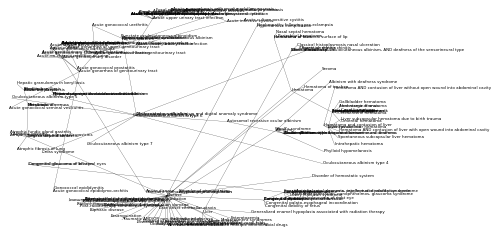

In [66]:
import matplotlib.pyplot as plt

# model = torch.load("poincare_model_dim_2.pt")
# coordinates = model["state_dict"]["embedding.weight"].numpy()
# print(model.state_dict()['embedding.weight'])
coordinates = model.embedding.weight
# print(coordinates)

# print(len(objects))
#print(data)

plt.figure()
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')

# import pandas
# ref = pandas.read_csv('~/Git/hyperbolic-learning/data/wordnet/ref.csv')
data, objects, weights = helpers.load_edge_list(Path("data", "dist1Sample.csv"))

for x in range(coordinates.shape[0]):
    plt.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
    # plt.annotate(dictData[x], (coordinates[x,0]*100, coordinates[x,1]*100),
    #              bbox={"fc":"white", "alpha":0.9}, fontsize=4)
i=0
print(data[i])
print(data[i][0])
print(data[i][1])
# print(coordinates)
print(coordinates[data[i][0], 0])
print(coordinates[data[i][0], 1])

print(coordinates[data[i][1], 0])
print(coordinates[data[i][1], 1])
# x_values = [coordinates[]]

for i in range(data.shape[0]):
    x_values = [coordinates[data[i][0], 0].detach().numpy(), coordinates[data[i][1], 0].detach().numpy()]
    y_values = [coordinates[data[i][0], 1].detach().numpy(), coordinates[data[i][1], 1].detach().numpy()]
#
#     x_val = [coordinates[data[x][0],0].detach().numpy(), coordinates[data[x][1],1].detach().numpy()]
#     y_val = [coordinates[data[x][0],0].detach().numpy(), coordinates[data[x][1],1].detach().numpy()]
    plt.plot(x_values, y_values, color="black", linewidth=0.2)

plt.savefig(Path("data", "hierarchy_embed.png"), dpi=300, facecolor="white")
plt.show()

# coordinates = model.embedding.weight
# coordinates = coordinates.detach().numpy()
# coordinates
#print(coordinates.shape[0])
# # print(coordinates)
# #pl.plot(pl.randn(100))
#
# for x in range(coordinates.shape[0]):
#     pl.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
#     # pl.scatter(coordinates[x,0], coordinates[x,1])
#     display.clear_output(wait=True)
#     display.display(pl.gcf())
#
#     # pl.annotate(dictData[x], (coordinates[x,0], coordinates[x,1]), fontsize=4)
#